In [1]:
import facebook as fb

import pandas as pd
import numpy as np

import datetime as dt
import pytz

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Access token for the Facebook Graph API
access_token = "XXX XXX XXX"

In [3]:
# Fan page ID or username
page_ids = ['xxxx', # more channels here
           ]

In [4]:
# Create a Facebook Graph API object
graph = fb.GraphAPI(access_token)

In [5]:
source_tz = 'UTC'  # Replace with your source time zone
target_tz = 'Asia/Bangkok'  # Replace with your target time zone

In [6]:
page_info_fields = 'id, name'

page_insights_fields_date_preset = 'last_90d'
page_insights_fields_period = 'day'
page_insights_fields_metric = 'page_engaged_users,page_post_engagements,page_impressions_organic_v2,page_impressions_organic_unique_v2,page_impressions_paid,page_impressions_paid_unique,page_posts_impressions_organic,page_posts_impressions_organic_unique,page_posts_impressions_paid,page_posts_impressions_paid_unique,page_fans,page_fan_adds,page_fan_adds_unique'
page_insights_fields = 'insights.date_preset({}).period({}).metric({})'.format(page_insights_fields_date_preset,page_insights_fields_period,page_insights_fields_metric)


post_analysis_date_preset = 'last_90d'
post_analysis_data = '{created_time,permalink_url,status_type,comments.summary(total_count),reactions.summary(total_count),shares,insights.metric(post_engaged_users,post_engaged_fan,post_clicks,post_clicks_unique,post_impressions,post_impressions_unique,post_impressions_fan,post_impressions_fan_unique)}'
post_analysis_fields = 'posts.date_preset({}){}'.format(post_analysis_date_preset, post_analysis_data)

In [7]:
def page_info(page_id, page_info_fields):
    page_info_list = []  # Initialize an empty list to store page information
    
    for page_id in page_ids:  # Loop through the page_ids (assuming it is defined outside the function)
        page_info_graph = graph.get_object(id = page_id, fields = page_info_fields)  # Fetch the page information using the provided page_id
        page_info_list.append(page_info_graph)  # Append the page information to the list
        
    page_info = pd.DataFrame(page_info_list)  # Create a DataFrame from the page_info_list
    if 'id' in page_info.columns:  # Check if the 'id' column exists in the DataFrame
        page_info = page_info.rename(columns={'id': 'page_id'})  # Rename the 'id' column to 'page_id'
    
    return page_info  # Return the resulting DataFrame containing the page information


In [8]:
page_info_df = page_info(page_ids, page_info_fields)
print(page_info_df.head())

           page_id                         name
0  982493555096370  KOC - Nhà Leo Núi Tương Lai


In [9]:
def page_insights(page_ids, page_insights_fields):
    page_insights_list = []  # Create an empty list to store page insights
    
    page_insights = pd.DataFrame(columns = ['page_id', 'period', 'date'])  # Create an empty DataFrame for page insights
    
    for page_id in page_ids:
        page_insights_graph = graph.get_object(id=page_id, fields=page_insights_fields)
        page_insights_list.append(page_insights_graph)  # Fetch and store page insights for each page_id
    
    for i in page_insights_list:
        for k in i['insights']['data']:
            k_df = pd.DataFrame(columns=['page_id', k['name'], 'period', 'date'])  # Create a new DataFrame for each metric data
            for j in k['values']:
                k_df.loc[len(k_df)] = {'page_id': i['id'], 'period': page_insights_fields_period, 'date': j['end_time'], k['name']: j['value']}  # Create a new row DataFrame for each 'j' value
            if page_insights.empty:
                page_insights = k_df  # Assign 'k_df' to 'page_insights' if it is empty
            else:
                page_insights = pd.merge(page_insights, k_df, on=['page_id', 'period', 'date'])  # Merge 'k_df' with 'page_insights' on common columns
    
    page_insights = page_insights.rename(columns = {'page_impressions_organic_v2': 'page_impressions_organic', 'page_impressions_organic_unique_v2': 'page_impressions_organic_unique'})
    page_insights['date'] = pd.to_datetime(page_insights['date']).dt.strftime("%Y-%m-%d")  # Convert 'date' column to desired date format
                
    return page_insights  # Return the final page insights DataFrame

In [10]:
page_insights_df = page_insights(page_ids, page_insights_fields)
page_insights(page_ids, page_insights_fields).head()

,page_id,page_engaged_users,period,date,page_post_engagements,page_impressions_organic,page_impressions_organic_unique,page_impressions_paid,page_impressions_paid_unique,page_posts_impressions_organic,page_posts_impressions_organic_unique,page_posts_impressions_paid,page_posts_impressions_paid_unique,page_fans,page_fan_adds,page_fan_adds_unique
0,982493555096370,23,day,2023-02-17,30,1398,419,0,0,1398,419,0,0,5310,3,3
1,982493555096370,4,day,2023-02-18,6,341,129,0,0,341,129,0,0,5310,0,0
2,982493555096370,4,day,2023-02-19,3,242,81,0,0,241,80,0,0,5312,2,2
3,982493555096370,6,day,2023-02-20,15,178,74,0,0,178,74,0,0,5312,0,0
4,982493555096370,3,day,2023-02-21,12,624,134,0,0,624,134,0,0,5311,0,0


In [11]:
def post_analysis(page_ids, post_analysis_fields):
    post_analysis_list = []  # Initialize an empty list to store post analysis information
    post_analysis_dict = {}  # Initialize an empty dictionary for post analysis
    post_analysis_dict_list = []  # Initialize an empty list to store dictionaries
    
    for page_id in page_ids:
        post_analysis_graph = graph.get_object(id=page_id, fields=post_analysis_fields)
        post_analysis_list.append(post_analysis_graph)  # Append post analysis graph of each id to the list
    
    for i in post_analysis_list:
        for k in i['posts']['data']:
            post_analysis_dict = {'page_id': i['id'], 'post_id': k['id'],'created_time': k['created_time'], 'permalink_url': k['permalink_url'], 'status_type': k['status_type'], 'total_comment': k['comments']['summary']['total_count'], 'total_reactions': k['reactions']['summary']['total_count']}
            
            for l in k['insights']['data']:
                post_analysis_dict[l['name']] = l['values'][0]['value']  # Add insights data to the dictionary
            
            post_analysis_dict_list.append(post_analysis_dict)  # Append the dictionary to the list
        
    post_analysis = pd.DataFrame(post_analysis_dict_list)  # Create a DataFrame from the list of dictionaries
    
    post_analysis['created_time'] = pd.to_datetime(post_analysis['created_time']).dt.tz_convert(target_tz) # Convert 'created_time' column to datetime
    
    return post_analysis  # Return the resulting DataFrame containing the post analysis information


In [12]:
post_analysis_df = post_analysis(page_ids, post_analysis_fields)
post_analysis(page_ids, post_analysis_fields).head(10)

,page_id,post_id,created_time,permalink_url,status_type,total_comment,total_reactions,post_engaged_users,post_engaged_fan,post_clicks,post_clicks_unique,post_impressions,post_impressions_unique,post_impressions_fan,post_impressions_fan_unique
0,982493555096370,982493555096370_6638005312878471,2023-05-06 20:00:17+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,27,98,884,425,2323,861,4729,3702,1634,1124
1,982493555096370,982493555096370_6634489569896712,2023-05-05 20:58:02+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,15,168,1578,675,4661,1516,11447,8271,3828,1772
2,982493555096370,982493555096370_6621949497817386,2023-05-02 08:10:55+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,0,93,299,222,409,244,1394,1180,816,632
3,982493555096370,982493555096370_6620290271316642,2023-05-01 20:30:40+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,9,57,153,108,219,113,1948,1630,761,565
4,982493555096370,982493555096370_6619223554756647,2023-05-01 12:30:09+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,15,43,168,126,284,148,1748,1480,707,543
5,982493555096370,982493555096370_6616014678410868,2023-04-30 12:15:38+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,13,51,148,95,216,115,1631,1416,674,526
6,982493555096370,982493555096370_6611056595573343,2023-04-29 00:02:19+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,10,49,139,94,151,97,1927,1655,718,546
7,982493555096370,982493555096370_6607724075906595,2023-04-28 00:01:01+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,19,63,140,106,149,90,1737,1442,668,481
8,982493555096370,982493555096370_6603917749620561,2023-04-26 20:21:37+07:00,https://www.facebook.com/982493555096370/posts...,added_video,21,74,193,122,291,149,1852,1458,699,438
9,982493555096370,982493555096370_6600849653260704,2023-04-25 21:10:35+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,13,52,145,101,168,108,1753,1404,751,529


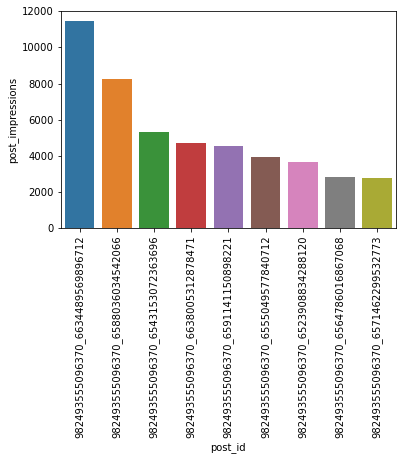

In [13]:
ax = sns.barplot(x = 'post_id', y = 'post_impressions', data = post_analysis_df.sort_values('post_impressions', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

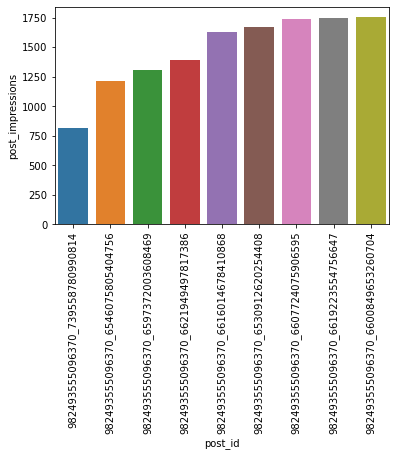

In [14]:
ax = sns.barplot(x = 'post_id', y = 'post_impressions', data = post_analysis_df.sort_values('post_impressions', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

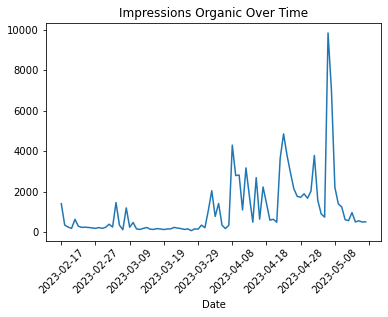

In [15]:
sns.lineplot(x = 'date', y = 'page_impressions_organic', data = page_insights_df)

plt.title('Impressions Organic Over Time')
plt.xlabel('Date')
plt.ylabel('')

plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

In [16]:
import os
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI

In [17]:
os.environ["OPENAI_API_KEY"] = 'sk-XXXX'

In [18]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), post_analysis_df, verbose=True)

In [19]:
def chatbot():
    while True:
        # Prompt the user for input
        user_input = input('You: ')

        # Check if user input is not "end" (case-insensitive)
        if user_input.lower() not in ["end", "End"]:
            # Call the agent's run method to process user input
            agent.run(user_input)
        else:
            # Break the loop if user input is "end" or "End"
            break


In [ ]:
chatbot()

You: You: What is the best time to post in a day?


> Entering new AgentExecutor chain...
Thought: I should look at the data to see when posts get the most engagement.
Action: python_repl_ast
Action Input: df.groupby(df['created_time'].dt.hour).sum()
Observation:               total_comment  total_reactions  post_engaged_users  \
created_time                                                       
0                        29              112                 279   
8                         0               93                 299   
12                       65              215                 999   
20                      308             1412                7691   
21                       73              402                1520   

              post_engaged_fan  post_clicks  post_clicks_unique  \
created_time                                                      
0                          200          300                 187   
8                          222          409               

Thought: The post with the highest post_impressions_unique is the post with the best performance
Final Answer: The post with the best performance is 982493555096370_6634489569896712.

> Finished chain.
